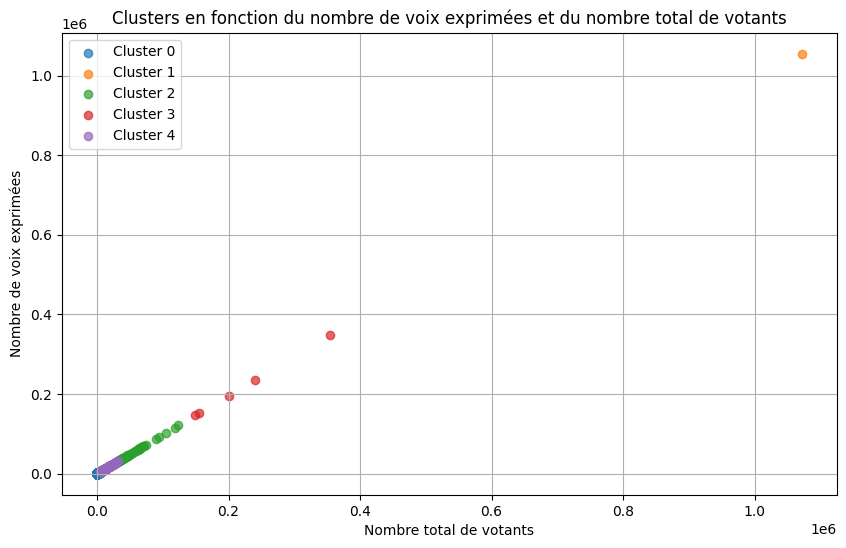

In [3]:
# Importation des modules nécessaires
import psycopg2
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Paramètres de connexion à la base de données PostgreSQL
conn_params = {
    "host": "localhost",
    "port": "15432", 
    "database": "postgres",
    "user": "admin",
    "password": "admin"
}

# Connexion à la base de données
conn = psycopg2.connect(**conn_params)

# Création d'un curseur pour exécuter des requêtes SQL
cur = conn.cursor()

# Requête SQL pour récupérer les données de la table election_2022_t1
query_election = """
    SELECT "Libellé de la commune", "Inscrits", "Abstentions", "Votants", "Blancs", "Nuls",
           "Exprimés", "Parti 1", "% Voix/Ins 1", "% Voix/Exp 1", "Parti 2", "% Voix/Ins 2",
           "% Voix/Exp 2", "Parti 3", "% Voix/Ins 3", "% Voix/Exp 3", "Parti 4", "% Voix/Ins 4",
           "% Voix/Exp 4", "Parti 5", "% Voix/Ins 5", "% Voix/Exp 5", "Parti 6", "% Voix/Ins 6",
           "% Voix/Exp 6", "Parti 7", "% Voix/Ins 7", "% Voix/Exp 7", "Parti 8", "% Voix/Ins 8",
           "% Voix/Exp 8", "Parti 9", "% Voix/Ins 9", "% Voix/Exp 9", "Parti 10", "% Voix/Ins 10",
           "% Voix/Exp 10", "Parti 11", "% Voix/Ins 11", "% Voix/Exp 11", "Parti 12", "% Voix/Ins 12",
           "% Voix/Exp 12", "winner", "code_postal"
    FROM election_2022_t1
"""
cur.execute(query_election)
rows_election = cur.fetchall()

# Création d'un DataFrame pour les données de l'élection
df_election = pd.DataFrame(rows_election, columns=["Libellé de la commune", "Inscrits", "Abstentions", "Votants", 
                                                    "Blancs", "Nuls", "Exprimés", "Parti 1", "% Voix/Ins 1", 
                                                    "% Voix/Exp 1", "Parti 2", "% Voix/Ins 2", "% Voix/Exp 2", 
                                                    "Parti 3", "% Voix/Ins 3", "% Voix/Exp 3", "Parti 4", 
                                                    "% Voix/Ins 4", "% Voix/Exp 4", "Parti 5", "% Voix/Ins 5", 
                                                    "% Voix/Exp 5", "Parti 6", "% Voix/Ins 6", "% Voix/Exp 6", 
                                                    "Parti 7", "% Voix/Ins 7", "% Voix/Exp 7", "Parti 8", 
                                                    "% Voix/Ins 8", "% Voix/Exp 8", "Parti 9", "% Voix/Ins 9", 
                                                    "% Voix/Exp 9", "Parti 10", "% Voix/Ins 10", "% Voix/Exp 10", 
                                                    "Parti 11", "% Voix/Ins 11", "% Voix/Exp 11", "Parti 12", 
                                                    "% Voix/Ins 12", "% Voix/Exp 12", "winner", "code_postal"])

# Requête SQL pour récupérer les données de la table economie
query_economie = """
    SELECT avg_1982, avg_1983, avg_1984, avg_1985, avg_1986, avg_1987, avg_1988, avg_1989, avg_1990,
           avg_1991, avg_1992, avg_1993, avg_1994, avg_1995, avg_1996, avg_1997, avg_1998, avg_1999,
           avg_2000, avg_2001, avg_2002, avg_2003, avg_2004, avg_2005, avg_2006, avg_2007, avg_2008,
           avg_2009, avg_2010, avg_2011, avg_2012, avg_2013, avg_2014, avg_2015, avg_2016, avg_2017,
           avg_2018, avg_2019, avg_2020, avg_2021, avg_2022, avg_2023, code_postal
    FROM economie
"""
cur.execute(query_economie)
rows_economie = cur.fetchall()

# Création d'un DataFrame pour les données économiques
df_economie = pd.DataFrame(rows_economie, columns=["avg_1982", "avg_1983", "avg_1984", "avg_1985", "avg_1986", 
                                                    "avg_1987", "avg_1988", "avg_1989", "avg_1990", "avg_1991", 
                                                    "avg_1992", "avg_1993", "avg_1994", "avg_1995", "avg_1996", 
                                                    "avg_1997", "avg_1998", "avg_1999", "avg_2000", "avg_2001", 
                                                    "avg_2002", "avg_2003", "avg_2004", "avg_2005", "avg_2006", 
                                                    "avg_2007", "avg_2008", "avg_2009", "avg_2010", "avg_2011", 
                                                    "avg_2012", "avg_2013", "avg_2014", "avg_2015", "avg_2016", 
                                                    "avg_2017", "avg_2018", "avg_2019", "avg_2020", "avg_2021", 
                                                    "avg_2022", "avg_2023", "code_postal"])

# Fermeture du curseur et de la connexion à la base de données
cur.close()
conn.close()

# Combinaison des DataFrames pour la formation du modèle de clustering
df_combined = pd.merge(df_election, df_economie, on="code_postal", how="inner")

# Création d'une instance de LabelEncoder
label_encoder = LabelEncoder()

# Encodage des étiquettes pour les colonnes catégorielles (partis politiques)
for i in range(1, 13):
    col = f"Parti {i}"
    df_combined[col] = label_encoder.fit_transform(df_combined[col])

# Sélection des colonnes à utiliser pour le clustering
X = df_combined.drop(columns=["Libellé de la commune", "winner", "code_postal"])

# Entraînement du modèle de clustering K-means
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X)

# Ajout des clusters prédits au DataFrame combiné
df_combined["cluster"] = kmeans.labels_

# Visualisation des clusters en fonction du nombre de voix exprimées et du nombre total de votants
plt.figure(figsize=(10, 6))
for cluster in range(5):
    cluster_data = df_combined[df_combined["cluster"] == cluster]
    plt.scatter(cluster_data["Votants"], cluster_data["Exprimés"], label=f"Cluster {cluster}", alpha=0.7)

plt.xlabel("Nombre total de votants")
plt.ylabel("Nombre de voix exprimées")
plt.title("Clusters en fonction du nombre de voix exprimées et du nombre total de votants")
plt.legend()
plt.grid(True)
plt.show()

